<a href="https://colab.research.google.com/github/Shaheer04/NutriScan/blob/main/PreTrainedFoodModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn



torch.__version__

'2.6.0+cu124'

import requests
import zipfile
from pathlib import Path # Importing the Path class from pathlib
data_path = Path("data")

if data_path.is_dir():
  print(f"{data_path} directory already exists")
else:
  print(f"creating {data_path} directory")
  data_path.mkdir(parents=True, exist_ok=True)

with open(data_path/ "Food-dataset.zip", "wb") as f:
  request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/raw/refs/heads/main/data/Food-dataset.zip")
  print("downloading dataset ....")
  f.write(request.content)

with zipfile.ZipFile(data_path / "Food-dataset.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(data_path)


In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")


with zipfile.ZipFile("/content/food_dataset_2.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(data_path)

Unzipping data...


In [3]:
from torchvision import datasets
# Load full dataset
full_dataset = datasets.ImageFolder(
    root='/content/data/food_dataset_2',
    transform=None  # No transform applied here yet
)


In [4]:
full_dataset.classes

['Biryani', 'Chai', 'Chapati', 'Chicken tikka', 'Paratha', 'Samosa']

In [5]:
full_dataset.class_to_idx

{'Biryani': 0,
 'Chai': 1,
 'Chapati': 2,
 'Chicken tikka': 3,
 'Paratha': 4,
 'Samosa': 5}

In [6]:
from torchvision import transforms
# Custom preprocessing pipeline
train_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to match pretrained model input
    transforms.RandomCrop(224),             # Standard size for ResNet/EfficientNet
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

In [7]:
from torch.utils.data import DataLoader, Subset, Dataset
# Custom dataset wrapper to apply transforms

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Get all indices and labels
indices = list(range(len(full_dataset)))
labels = [full_dataset[i][1] for i in range(len(full_dataset))]

# Perform stratified split
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create subsets with transforms
train_subset = TransformDataset(
    Subset(full_dataset, train_indices),
    transform=train_transform
)

test_subset = TransformDataset(
    Subset(full_dataset, test_indices),
    transform=test_transform
)

In [9]:
# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [10]:
# Verify the new distribution
train_class_counts = {}
for _, labels in train_loader:
    for label in labels:
        if label.item() in train_class_counts:
            train_class_counts[label.item()] += 1
        else:
            train_class_counts[label.item()] = 1

val_class_counts = {}
for _, labels in test_loader:
    for label in labels:
        if label.item() in val_class_counts:
            val_class_counts[label.item()] += 1
        else:
            val_class_counts[label.item()] = 1

print("Training class distribution:")
for class_idx in sorted(train_class_counts.keys()):
    print(f"Class {class_idx}: {train_class_counts[class_idx]} samples")

print("\nValidation class distribution:")
for class_idx in sorted(val_class_counts.keys()):
    print(f"Class {class_idx}: {val_class_counts[class_idx]} samples")

Training class distribution:
Class 0: 612 samples
Class 1: 612 samples
Class 2: 612 samples
Class 3: 612 samples
Class 4: 612 samples
Class 5: 612 samples

Validation class distribution:
Class 0: 153 samples
Class 1: 153 samples
Class 2: 153 samples
Class 3: 153 samples
Class 4: 153 samples
Class 5: 153 samples


In [11]:
class_names = full_dataset.classes
class_names

['Biryani', 'Chai', 'Chapati', 'Chicken tikka', 'Paratha', 'Samosa']

In [12]:
import matplotlib.pyplot as plt
import random
# 1. Create a function to take in a dataset
from typing import List
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


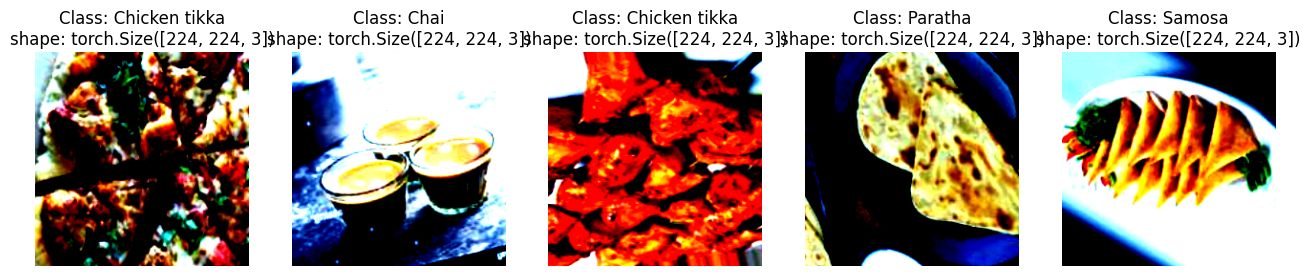

In [13]:
# Display random images from the ImageFolder created Dataset
display_random_images(test_subset,
                      n=5,
                      classes=class_names,
                      seed=None)

In [14]:
import torch
import torchvision.models as models

# Load pretrained model
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Replace final layer (adjust num_classes to case)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [15]:
import torch.optim as optim

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (only train the classifier first)
optimizer = optim.SGD([
    {'params': model.fc.parameters(), 'lr':5e-4},
], momentum=0.9, weight_decay=1e-3)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [16]:
num_epochs = 50
best_val_acc = 0.0
metrics = {"train_loss" : [],
           "train_acc": [],
           "test_loss" : [],
           "val_acc": [],
           }

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    train_acc = train_correct / train_total
    val_acc = correct / total


    # Update scheduler
    scheduler.step(val_loss)

    # Saving Metrics for Plotting
    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["test_loss"].append(val_loss)
    metrics["val_acc"].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"Train Loss: {train_loss:.4f} | Train Acc : {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50
Train Loss: 1.3494 | Train Acc : 0.5278 | Val Loss: 0.8749 | Val Acc: 0.8017
Epoch 11/50
Train Loss: 0.3796 | Train Acc : 0.8862 | Val Loss: 0.3386 | Val Acc: 0.9009
Epoch 21/50
Train Loss: 0.3206 | Train Acc : 0.8903 | Val Loss: 0.2906 | Val Acc: 0.9085
Epoch 31/50
Train Loss: 0.2820 | Train Acc : 0.9050 | Val Loss: 0.2714 | Val Acc: 0.9074
Epoch 41/50
Train Loss: 0.2540 | Train Acc : 0.9186 | Val Loss: 0.2529 | Val Acc: 0.9150


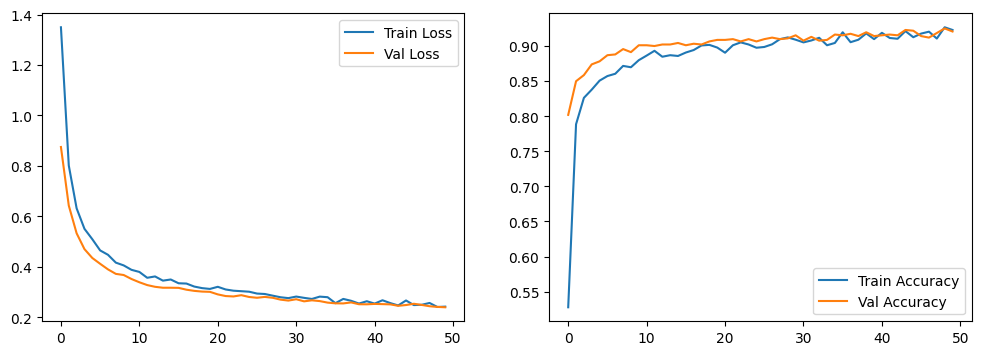

In [17]:
import matplotlib.pyplot as plt

# Plot loss and accuracy curves (after training)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics["train_loss"], label='Train Loss')
plt.plot(metrics["test_loss"], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics["train_acc"], label='Train Accuracy')
plt.plot(metrics["val_acc"], label='Val Accuracy')
plt.legend()
plt.show()

In [18]:
import requests

custom_image_path = data_path / "biryani.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/blob/main/test_imgs/biryani_img.jpg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")


In [19]:
import torchvision
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.7765, 0.7686, 0.7608,  ..., 0.5725, 0.5961, 0.6118],
         [0.7922, 0.7882, 0.7882,  ..., 0.5882, 0.6039, 0.6118],
         [0.7882, 0.7843, 0.7843,  ..., 0.6157, 0.6235, 0.6235],
         ...,
         [0.7059, 0.6941, 0.6863,  ..., 0.0863, 0.0784, 0.0824],
         [0.6902, 0.6863, 0.6863,  ..., 0.2392, 0.2392, 0.2431],
         [0.6784, 0.6745, 0.6824,  ..., 0.2745, 0.2902, 0.2863]],

        [[0.8902, 0.8824, 0.8784,  ..., 0.4431, 0.4745, 0.4902],
         [0.9059, 0.9020, 0.9059,  ..., 0.4588, 0.4745, 0.4902],
         [0.8941, 0.8902, 0.8941,  ..., 0.4902, 0.4980, 0.4980],
         ...,
         [0.4980, 0.4863, 0.4784,  ..., 0.0000, 0.0000, 0.0000],
         [0.4824, 0.4784, 0.4784,  ..., 0.1255, 0.1137, 0.1216],
         [0.4706, 0.4667, 0.4745,  ..., 0.1490, 0.1529, 0.1490]],

        [[0.9608, 0.9451, 0.9216,  ..., 0.0235, 0.0510, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0392, 0.0549, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0627, 0.0706, 0.

In [21]:
# Create transform pipeline to resize image
from torchvision import transforms
from PIL import Image

custom_image_transform = transforms.Compose([
    transforms.Resize(256),            # Resize to match pretrained model input
    transforms.RandomCrop(224),        # Standard size for ResNet/EfficientNet
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float), # Standard size for ResNet/EfficientNet
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

# Open the image using PIL
custom_image_pil = Image.open(custom_image_path).convert('RGB')  # Ensure RGB format

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image_pil)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 720, 1280])
Transformed shape: torch.Size([3, 224, 224])


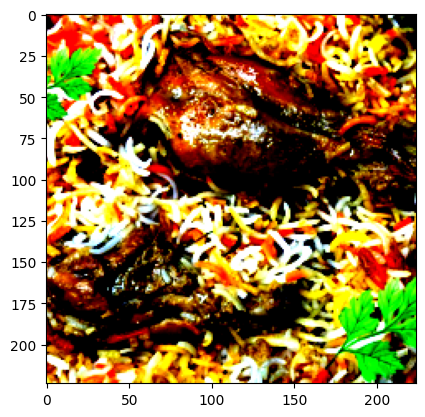

In [22]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [23]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [24]:
model.eval()
with torch.inference_mode():
  custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 2.8083,  0.4129, -4.0646, -2.5410,  2.1719, -0.2690]],
       device='cuda:0')

In [25]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.5980, 0.0545, 0.0006, 0.0028, 0.3165, 0.0276]], device='cuda:0')

In [26]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [27]:
class_names[custom_image_pred_label]

'Biryani'

In [32]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform,  # This should be your test_transform
                        device=device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction."""
    # Load in the image using PIL for proper preprocessing
    from PIL import Image
    target_image_pil = Image.open(image_path).convert('RGB')

    # Apply the same transformations as test data
    if transform:
        target_image = transform(target_image_pil)
    else:
        # Fallback if no transform provided (not recommended)
        target_image = torchvision.transforms.ToTensor()(target_image_pil)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (batch dimension)
        target_image_batch = target_image.unsqueeze(0).to(device)

        # Make a prediction on the image
        target_image_pred = model(target_image_batch)

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the original image (without normalization for viewing)
    plt.figure(figsize=(8, 6))
    plt.imshow(target_image_pil)

    # Create title with all class probabilities for debugging
    probs = target_image_pred_probs[0].cpu().detach().numpy()
    pred_label = target_image_pred_label.cpu().item()
    confidence = probs.max() * 100

    if class_names:
        title = f"Predicted: {class_names[pred_label]} ({confidence:.2f}%)\n"
        title += f"All Probabilities:\n"
        for i, prob in enumerate(probs):
            title += f"{class_names[i]}: {prob*100:.2f}% | "
            if (i + 1) % 3 == 0:  # Line break every 3 classes
                title += "\n"
    else:
        title = f"Predicted: Class {pred_label} ({confidence:.2f}%)"

    plt.title(title, fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


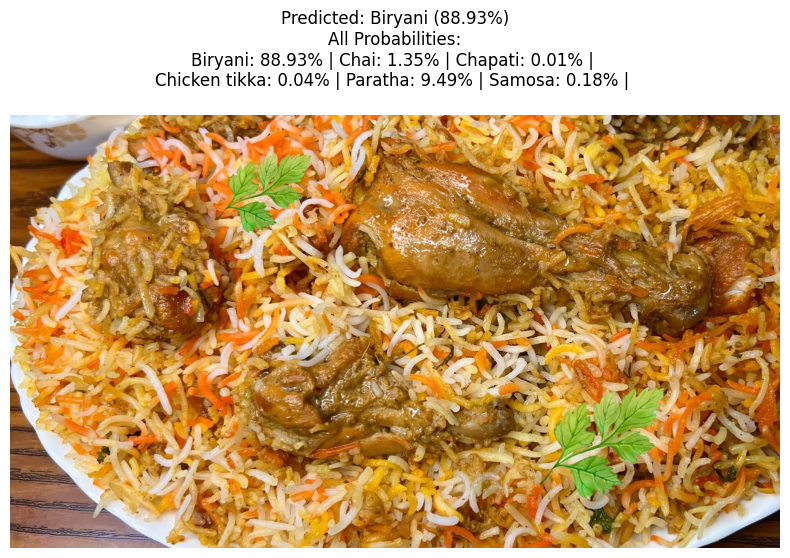

In [33]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_transform,
                    device=device)

In [34]:
class_names

['Biryani', 'Chai', 'Chapati', 'Chicken tikka', 'Paratha', 'Samosa']